序列到序列的学习 Seq to Seq

In [15]:
import collections
import math
import torch

from torch import nn
from d2l import torch as d2l

实现循环神经网络的Encoder编码器部分

我们使用了嵌入层（embedding layer） 来获得输入序列中每个词元的特征向量。 \
嵌入层的权重是一个矩阵\
其行数等于输入词表的大小（vocab_size）， 其列数等于特征向量的维度embed_size。\
对于任意输入词元的索引i， 嵌入层获取权重矩阵的第i行（从0开始）以返回其特征向量。\
另外，本文选择了一个多层门控循环单元来实现编码器。

In [16]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)

        # 嵌入层Embedding
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 训练网络 这里不需要输出层
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout = dropout)

    def forward(self, X, *args):

        # 输出'X'的形状：(batch_size,num_steps,num_hiddens)
        X = self.embedding(X)
        
        # 在循环神经网络模型中，第一个轴对应于时间步 [num_steps, batch_size,num_hiddens]
        X = X.permute(1, 0, 2)

        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)

        # 返回的是最后的输出和每一层最后的状态
        return output, state

实例化编码器

In [17]:
from os import stat


encoder = Seq2SeqEncoder(
    vocab_size=10,
    embed_size=8,
    num_hiddens=16,
    num_layers=2
)
encoder.eval()
# 将一个batch-size = 4 sentence-length = 7作为案例
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)

# [7, 4, 16] -> [句子长度, 小批量大小, 隐藏层大小]
# [2, 4, 16] -> [层数,  小批量大小, 隐藏层大小] 
print("output:",output.shape,"state",state.shape)

output: torch.Size([7, 4, 16]) state torch.Size([2, 4, 16])


解码器Decoder

In [18]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder,self).__init__(**kwargs)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens,
            num_hiddens,
            num_layers,
            dropout=dropout
            )
        # decoder是需要输出的 将RNN的输出(大小为num_hiddens)输出成目标个数vocab_size
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    # decoder的返回有两个部分 outputs 和 state 这个地方只是取出state
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # [num_steps, batch_size,num_hiddens]
        X = self.embedding(X).permute(1, 0, 2)

        # state : 最后一时刻的隐藏状态
        # state[-1] : 最后一时刻的最后一层的隐藏状态输出
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)

        # 将这里的输入X与刚才广播的最后一层的state拼接在一起
        X_and_context = torch.cat((X, context), 2)

        output, state = self.rnn(X_and_context, state)
        # 将batch-size重新放到最前面
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

实例化解码器

In [19]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()

# 取出encoder的输出 并且只取出其中state部分
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape
# [7, 4, 10] -> [句子长度, 小批量大小, vocab-size]
# [2, 4, 16] -> [层数,  小批量大小, 隐藏层大小] 

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

通过零值化屏蔽不相关项

In [20]:
def sequence_mask(X, valid_len, value=0):

    maxlen = X.size(1)
    mask = torch.arange(
        (maxlen),
        dtype = torch.float32,
        device = X.device
        )[None, : ] < valid_len[:,None]
    # Tensor中利用None来增加维度，可以简单的理解为在None的位置上增加一维，
    # 新增维度大小为1，同时有几个None就会增加几个维度。
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [21]:
X = torch.ones(2, 3, 4)
# batch-size = 2 对应了下文中 torch.tensor([1,2]) 
# 第一个句子中有效长度是1 第二个sentence中valid—size=2
sequence_mask(X, torch.tensor([1, 2]), value=0)

tensor([[[1., 1., 1., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]]])

通过拓展softmax交叉熵损失来屏蔽不相关项\
最初，所有预测词元的掩码都设置为1。\
一旦给定了有效长度，与填充词元对应的掩码将被设置为0。 \
最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [22]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights,valid_len)

        self.reduction = 'none'

        unweighted_loss = super(MaskedSoftmaxCELoss,self).forward(
            pred.permute(0, 2, 1), label
        )
        # mean(dim=1)对每个句子取一个平均
        weighted_loss = (unweighted_loss * weights).mean(dim=1)

        return weighted_loss


In [23]:
loss = MaskedSoftmaxCELoss()
loss(
    # 可以创建三个相同的序列来进行代码健全性检查， 
    # 然后分别指定这些序列的有效长度为4、2和0。 
    # 结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。
    pred = torch.ones(3, 4, 10), 
    label = torch.ones((3, 4), dtype=torch.long),
    # 有效长度分别为4, 2, 0
    valid_len = torch.tensor([4, 2, 0])
    )

tensor([2.3026, 1.1513, 0.0000])

在下面的循环训练过程中，\
特定的序列开始词元“< bos >”和原始的输出序列不包括序列结束词元“< eos >” 拼接在一起作解码器的输入。 \
这被称为强制教学,因为原始的输出序列（词元的标签）被送入解码器。 \
或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [24]:
from pickletools import optimize


def train_seq2seq(
    net,data_iter,lr,
    num_epochs,target_vocab,device
    ):
    def xavier_init_weights(m):
        
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)

        if type(m) == nn.GRU:
            for param in m._flat_weight_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    # torch.nn.init.xavier_uniform_是一个服从均匀分布的Glorot初始化器
    # net.apply(xavier_init_weights)
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()

    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs])

    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量

        for batch in data_iter:
            optimizer.zero_grad()
            # 读取信息
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            # 构建 <bos> 并且把bos加载到 decoder的inputs：Y中 (把原句子最后一个字符拿掉，用bos代替)
            bos = torch.tensor([target_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学

            # 把X与整理后的Y输入进网络
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)

            # 损失函数的标量进行“反向传播”
            l.sum().backward()

            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)

        # 每10轮保存一次数据
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

    

In [25]:
# class EncoderDecoder(nn.Module):
#     """The base class for the encoder-decoder architecture.

#     Defined in :numref:`sec_encoder-decoder`"""
#     def __init__(self, encoder, decoder, **kwargs):
#         super(EncoderDecoder, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, enc_X, dec_X, *args):
#         enc_outputs = self.encoder(enc_X, *args)
#         dec_state = self.decoder.init_state(enc_outputs, *args)
#         return self.decoder(dec_X, dec_state)


loss 0.020, 12484.3 tokens/sec on cuda:0


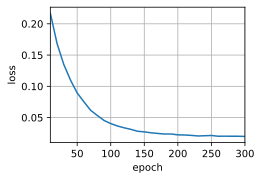

In [26]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = Seq2SeqEncoder(
    len(src_vocab), 
    embed_size, 
    num_hiddens, 
    num_layers,dropout
    )
    
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

预测函数

In [27]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    net.eval()
    
    # 将模型的输入句子划分开以后，查找vocab找到对应的feature vector 并且加上<eos>
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    # 获取到有效的输入长度
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    # 填充不足，剪裁过多
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])

    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device),dim=0
    )

    # 投入模型输出并返回encoder中的state
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)

    # 投入一个开始信息bos，
    # 并且需要一个一个投入decoder做预测，因此使用unsqueeze升一个维度，这样就可以逐个取出
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)

    output_seq, attention_weight_seq = [], []

    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)

        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)

        # squeeze开始降为处理，用于预测
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()

        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)

        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

BLUE

In [28]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [29]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va <unk> ., bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis chez s'est boulot ., bleu 0.649
